<a href="https://colab.research.google.com/github/HoarfrostRaven/Optimization-for-Machine-Learning/blob/main/OML_Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, norm, svdvals
from numpy.random import multivariate_normal, randn

In [ ]:
# Generate data for linear least squares. This code is based on a generator proposed by Alexandre Gramfort (INRIA).
def simu_linreg(wtruth, n, std=1., corr=0.5):
    """
    Generation of data from a linear trend corrupted by Gaussian noise.

    Inputs
    ----------
    wtruth: np.ndarray, shape=(d,)
        Ground truth coefficients

    n: int
        Sample size

    std: float, default=1.
        Standard deviation for the noise

    corr: float, default=0.5
        Correlation for the feature matrix

    Outputs
    ------------
    X: Feature matrix
    y: Label vector

    """
    d = wtruth.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    # Main relationship
    y = X.dot(wtruth) + noise
    return X, y

In [ ]:
# 线性回归问题类
class LinReg:
    def __init__(self, X, y, lbda=0):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda  # 正则化系数

    # 计算目标函数值
    def fun(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.

    # 计算梯度
    def grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y) / self.n + self.lbda * w

    # 计算梯度的 Lipschitz 常数
    def lipgrad(self):
        return norm(self.X, ord=2) ** 2 / self.n + self.lbda

In [ ]:
# 生成两个数据集 (Question 2.1)
np.random.seed(42)
d = 50
n = 1000
w_star = (-1) ** np.arange(d) * np.exp(-np.arange(d) / 10.)  # 真实权重向量

In [ ]:
# 生成第一个数据集 (X1, y1)
X1, y1 = simu_linreg(w_star, n, std=3., corr=0.1)

In [ ]:
# 生成第二个数据集 (X2, y2)
X2, y2 = simu_linreg(w_star, n, std=3., corr=0.1)

In [ ]:
# 梯度下降实现
def gradient_descent(problem, w_init, eta=0.1, num_iters=100):
    w = w_init.copy()
    obj_vals = []

    for _ in range(num_iters):
        grad = problem.grad(w)
        w -= eta * grad
        obj_vals.append(problem.fun(w))

    return w, np.array(obj_vals)

In [ ]:
# 运行梯度下降（确保正则化参数被正确传递）
w_init = np.zeros(d)

In [ ]:
# 1. 无正则化
pblinreg1_no_reg = LinReg(X1, y1, lbda=0)
w_no_reg, obj_vals_no_reg = gradient_descent(pblinreg1_no_reg, w_init, eta=0.1, num_iters=100)

In [ ]:
# 2. 适中正则化（λ=0.1）
pblinreg1_reg = LinReg(X1, y1, lbda=0.1)
w_reg, obj_vals_reg = gradient_descent(pblinreg1_reg, w_init, eta=0.1, num_iters=100)

In [ ]:
# 3. 强正则化（λ=1）
pblinreg1_strong_reg = LinReg(X1, y1, lbda=1)
w_strong_reg, obj_vals_strong_reg = gradient_descent(pblinreg1_strong_reg, w_init, eta=0.1, num_iters=100)

In [ ]:
def objective_function(problem, w):
    return problem.fun(w)

In [ ]:
# 计算在第二个数据集上的目标函数值
obj_no_reg = objective_function(LinReg(X2, y2, lbda=0), w_no_reg)
obj_reg = objective_function(LinReg(X2, y2, lbda=0), w_reg)
obj_strong_reg = objective_function(LinReg(X2, y2, lbda=0), w_strong_reg)

print(f"无正则化目标函数值: {obj_no_reg}")
print(f"适中正则化目标函数值: {obj_reg}")
print(f"强正则化目标函数值: {obj_strong_reg}")

无正则化目标函数值: 4.757613821798799
适中正则化目标函数值: 4.711954330450649
强正则化目标函数值: 5.09895385323397


In [ ]:
# 观察正则化对 `w` 的影响
print("w_no_reg mean:", np.mean(w_no_reg))
print("w_reg mean:", np.mean(w_reg))
print("w_strong_reg mean:", np.mean(w_strong_reg))

print("w_no_reg norm:", np.linalg.norm(w_no_reg))
print("w_reg norm:", np.linalg.norm(w_reg))
print("w_strong_reg norm:", np.linalg.norm(w_strong_reg))

w_no_reg mean: 0.0130842872016112
w_reg mean: 0.012584096461874396
w_strong_reg mean: 0.008462461715244117
w_no_reg norm: 2.364494917376544
w_reg norm: 2.0962742852472886
w_strong_reg norm: 1.0593895000684184


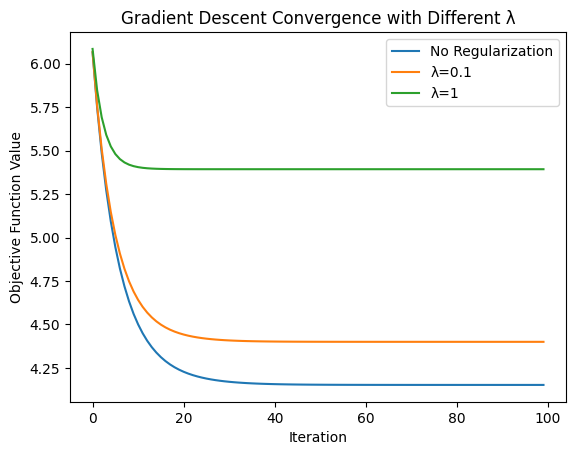

In [ ]:
# 绘制收敛曲线
plt.plot(obj_vals_no_reg, label="No Regularization")
plt.plot(obj_vals_reg, label="λ=0.1")
plt.plot(obj_vals_strong_reg, label="λ=1")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.legend()
plt.title("Gradient Descent Convergence with Different λ")
plt.show()

In [ ]:
# (Question 2.3) 修改后的随机梯度下降 (SGD)
def stochastic_gradient_descent(problem, w_init, eta=0.1, num_iters=100, batch_size=10):
    """
    Stochastic Gradient Descent (SGD) with minibatch updates.

    Parameters:
    - problem: LinReg instance (包含正则化参数 lambda)
    - w_init: 初始权重
    - eta: 学习率
    - num_iters: 迭代次数
    - batch_size: 每次更新时使用的样本数量

    Returns:
    - w: 最终学习到的权重
    - obj_vals: 目标函数值的变化过程
    """
    n, d = problem.X.shape
    w = w_init.copy()
    obj_vals = []

    for _ in range(num_iters):
        indices = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = problem.X[indices], problem.y[indices]

        # 计算梯度（使用 problem.lbda 作为正则化参数）
        grad = X_batch.T.dot(X_batch.dot(w) - y_batch) / batch_size + problem.lbda * w
        w -= eta * grad

        obj_vals.append(problem.fun(w))

    return w, np.array(obj_vals)

In [ ]:
# 重新初始化 LinReg 实例，确保正则化参数生效
pblinreg1_no_reg_sgd = LinReg(X1, y1, lbda=0)
pblinreg1_reg_sgd = LinReg(X1, y1, lbda=0.1)
pblinreg1_strong_reg_sgd = LinReg(X1, y1, lbda=1)

In [ ]:
# 运行 SGD 无正则化
w_no_reg_sgd, obj_vals_no_reg_sgd = stochastic_gradient_descent(pblinreg1_no_reg_sgd, w_init, eta=0.01, num_iters=1000)

In [ ]:
# 运行 SGD 适中正则化 (λ=0.1)
w_reg_sgd, obj_vals_reg_sgd = stochastic_gradient_descent(pblinreg1_reg_sgd, w_init, eta=0.01, num_iters=1000)

In [ ]:
# 运行 SGD 强正则化 (λ=1)
w_strong_reg_sgd, obj_vals_strong_reg_sgd = stochastic_gradient_descent(pblinreg1_strong_reg_sgd, w_init, eta=0.01, num_iters=1000)

In [ ]:
# 计算 SGD 在第二个数据集上的目标函数值
obj_no_reg_sgd = objective_function(LinReg(X2, y2, lbda=0), w_no_reg_sgd)
obj_reg_sgd = objective_function(LinReg(X2, y2, lbda=0), w_reg_sgd)
obj_strong_reg_sgd = objective_function(LinReg(X2, y2, lbda=0), w_strong_reg_sgd)

print(f"无正则化 (SGD) 目标函数值: {obj_no_reg_sgd}")
print(f"适中正则化 (SGD) 目标函数值: {obj_reg_sgd}")
print(f"强正则化 (SGD) 目标函数值: {obj_strong_reg_sgd}")

无正则化 (SGD) 目标函数值: 4.862589538885371
适中正则化 (SGD) 目标函数值: 4.785939578511017
强正则化 (SGD) 目标函数值: 5.089479687763006


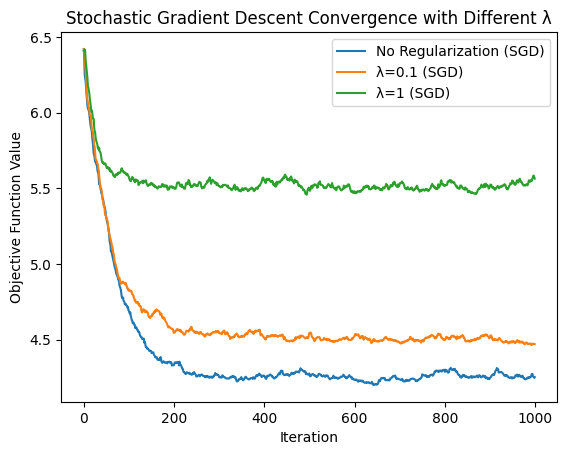

In [ ]:
# 绘制 SGD 收敛曲线
plt.plot(obj_vals_no_reg_sgd, label="No Regularization (SGD)")
plt.plot(obj_vals_reg_sgd, label="λ=0.1 (SGD)")
plt.plot(obj_vals_strong_reg_sgd, label="λ=1 (SGD)")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.legend()
plt.title("Stochastic Gradient Descent Convergence with Different λ")
plt.show()

#  Binary classification on real-world data

In [ ]:
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

In [ ]:
# 下载数据集到本地
!wget -q https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a -O a9a
!wget -q https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a.t -O a9a.t

In [ ]:
# 读取训练和测试数据
X_train, y_train = load_svmlight_file("a9a")
X_test, y_test = load_svmlight_file("a9a.t")

In [ ]:
# 检查数据维度
print(f"训练集 X 形状: {X_train.shape}, y 形状: {y_train.shape}")
print(f"测试集 X 形状: {X_test.shape}, y 形状: {y_test.shape}")

训练集 X 形状: (32561, 123), y 形状: (32561,)
测试集 X 形状: (16281, 122), y 形状: (16281,)


In [ ]:
# 检查并补齐测试集的特征数
train_dim = X_train.shape[1]
test_dim = X_test.shape[1]
if test_dim < train_dim:
    missing_features = train_dim - test_dim
    print(f"测试集比训练集少了 {missing_features} 个特征，自动填充零向量")
    # 用 0 填充缺失特征，使测试集与训练集的特征数一致
    X_test = hstack([X_test, np.zeros((X_test.shape[0], missing_features))])
    print(f"修正后测试集 X 形状: {X_test.shape}")

测试集比训练集少了 1 个特征，自动填充零向量
修正后测试集 X 形状: (16281, 123)


In [ ]:
# 转换为 NumPy 数组
X_train = X_train.toarray()
X_test = X_test.toarray()

In [ ]:
# 标准化数据
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 训练集 & 验证集拆分 (80% 训练, 20% 验证)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# 输出数据形状
print(f"训练集: {X_train.shape}, 验证集: {X_val.shape}, 测试集: {X_test.shape}")

训练集: (26048, 123), 验证集: (6513, 123), 测试集: (16281, 123)


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
def loss_gradient(X, y, w):
    """计算平方损失的梯度"""
    pred = sigmoid(X @ w)
    error = (y - pred)
    grad = -2 * (X.T @ (error * pred * (1 - pred))) / len(y)
    return grad

In [ ]:
def stochastic_gradient_descent(X, y, w_init, eta=0.1, lambda_=0, num_iters=100, batch_size=10):
    """SGD for logistic regression with L2 regularization"""
    n, d = X.shape
    w = w_init.copy()
    obj_vals = []

    for _ in range(num_iters):
        indices = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X[indices], y[indices]

        # 计算梯度
        grad = loss_gradient(X_batch, y_batch, w) + lambda_ * w
        w -= eta * grad  # 更新参数

        # 记录目标函数值
        obj_vals.append(np.mean((y - sigmoid(X @ w))**2) + (lambda_ / 2) * np.linalg.norm(w)**2)

    return w, np.array(obj_vals)

In [ ]:
# 我们在 λ = [0, 0.01, 0.1, 1, 10] 之间选择最优 λ
def cross_validation(lambda_values, X_train, y_train, X_val, y_val, eta=0.1, num_iters=100):
    """交叉验证选择最佳 λ"""
    results = {}
    best_lambda = None
    min_mse = float("inf")

    for lambda_ in lambda_values:
        w_init = np.zeros(X_train.shape[1])
        w, _ = stochastic_gradient_descent(X_train, y_train, w_init, eta=eta, lambda_=lambda_, num_iters=num_iters)

        # 在验证集上计算 MSE
        mse_val = np.mean((y_val - sigmoid(X_val @ w)) ** 2)
        results[lambda_] = mse_val

        if mse_val < min_mse:
            min_mse = mse_val
            best_lambda = lambda_

    return best_lambda, results

In [ ]:
# 运行交叉验证：
lambda_values = [0, 0.01, 0.1, 1, 10]
best_lambda, val_results = cross_validation(lambda_values, X_train, y_train, X_val, y_val)

print("交叉验证结果:")
for lbda, mse_val in val_results.items():
    print(f"λ={lbda}: 验证集 MSE = {mse_val}")

print(f"最佳 λ = {best_lambda}")

交叉验证结果:
λ=0: 验证集 MSE = 1.490867852519153
λ=0.01: 验证集 MSE = 1.4883041963690573
λ=0.1: 验证集 MSE = 1.5134543494308117
λ=1: 验证集 MSE = 1.628128606593276
λ=10: 验证集 MSE = 1.7295119820916303
最佳 λ = 0.01


In [ ]:
# 训练最终模型
w_init = np.zeros(X_train.shape[1])
best_model, _ = stochastic_gradient_descent(X_train, y_train, w_init, eta=0.1, lambda_=best_lambda, num_iters=100)

In [ ]:
# 计算测试集误差
test_mse = np.mean((y_test - sigmoid(X_test @ best_model)) ** 2)
print(f"最终模型的测试集 MSE: {test_mse}")

最终模型的测试集 MSE: 1.48642744434093


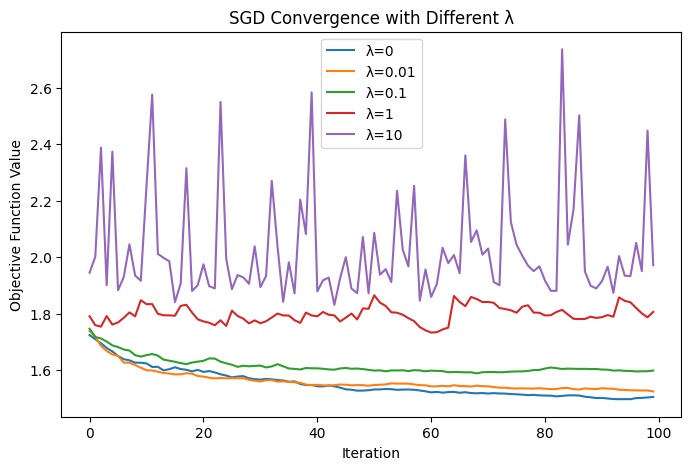

In [ ]:
plt.figure(figsize=(8, 5))
for lambda_ in lambda_values:
    w_init = np.zeros(X_train.shape[1])
    _, obj_vals = stochastic_gradient_descent(X_train, y_train, w_init, eta=0.1, lambda_=lambda_, num_iters=100)
    plt.plot(obj_vals, label=f"λ={lambda_}")

plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.legend()
plt.title("SGD Convergence with Different λ")
plt.show()